In [2]:
import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(context='talk', style='whitegrid')

# 2a) BENCHMARK: NAIVE FORECASTING

## (i) Data Preparation

In [3]:
# import data
data = pd.read_csv('ninja_wind_49.0069_8.4034_corrected.csv', skiprows=3)

# set datetime index
data.index = [datetime.datetime.strptime(row, '%Y-%m-%d %H:%M') for row in data['time']]

# drop unnecessary columns
data = data.drop(['local_time'], axis=1)

## (ii) Naive Forecasting

In [4]:
def get_naive_forecast(df, time):   
    past_generation_list = []
    
    # get same hour of the previous 7 days
    for i in range(1, 8):
        
        # get same hour from i days earlier
        time_past = time - datetime.timedelta(days=i)
        
        # get wind generation of this hour
        past_generation = df.loc[time_past, 'electricity']
        
        # store in list
        past_generation_list.append(past_generation)
    
    return np.mean(past_generation_list)   

In [5]:
# define time window
year = 2019
month = 12
days = range(2, 9)
hours = range(24)

start_date = datetime.datetime(year, month, 2)
end_date = datetime.datetime(year, month, 8, 23)

# prepare DataFrame to store the forecasts
df_results = data.copy().loc[start_date : end_date]
df_results = df_results.rename(columns={'electricity': 'Actual'})
df_results['Naive Forecast'] = 0

# make predictions
for day in days:
    for hour in hours:
        time = datetime.datetime(year, month, day, hour)
        
        # get forecast and add it to the DataFrame
        df_results.at[time, 'Naive Forecast'] = get_naive_forecast(data, time)

In [6]:
df_results

,time,Actual,Naive Forecast
2019-12-02 00:00:00,2019-12-02 00:00,0.719,2.822000
2019-12-02 01:00:00,2019-12-02 01:00,0.679,2.734143
2019-12-02 02:00:00,2019-12-02 02:00,0.794,2.649143
2019-12-02 03:00:00,2019-12-02 03:00,0.875,2.536143
2019-12-02 04:00:00,2019-12-02 04:00,0.811,2.529286
...,...,...,...
2019-12-08 19:00:00,2019-12-08 19:00,6.330,1.978571
2019-12-08 20:00:00,2019-12-08 20:00,5.978,2.073286
2019-12-08 21:00:00,2019-12-08 21:00,5.942,2.186000
2019-12-08 22:00:00,2019-12-08 22:00,5.926,2.299571


## (iii) Evaluation of Forecasting Performance

In [7]:
# mean absolute percentage error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# root mean squared error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [8]:
# MSE
mean_squared_error(df_results['Actual'], df_results['Naive Forecast'])

7.619083473639456

In [9]:
# RMSE
rmse(df_results['Actual'], df_results['Naive Forecast'])

2.760268732141756

In [10]:
# MAE
mean_absolute_error(df_results['Actual'], df_results['Naive Forecast'])

2.290706632653061

In [11]:
# MAPE
mape(df_results['Actual'], df_results['Naive Forecast'])

537.4479096985003

<AxesSubplot: >

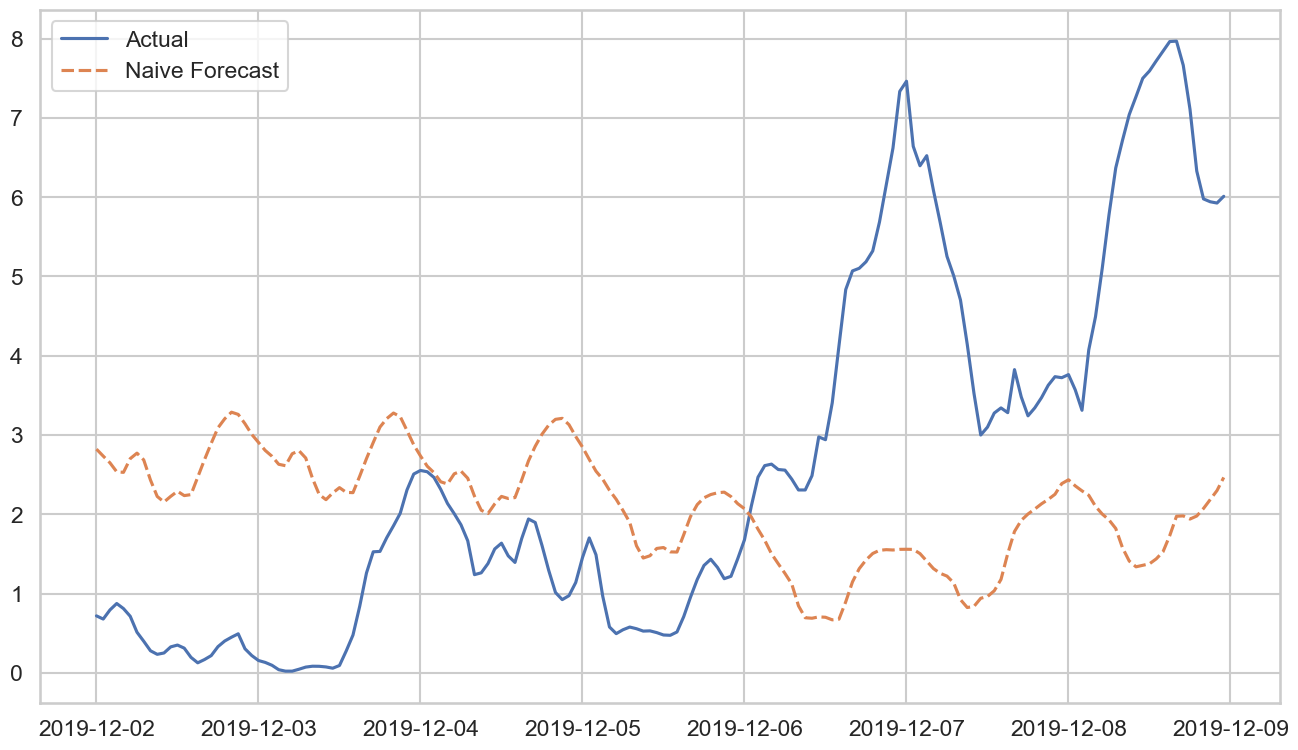

In [12]:
plt.figure(figsize=(16, 9))
sns.lineplot(df_results)

#  2b) ARTIFICIAL NEURAL NETWORK FORECASTING

## (i) Data Preparation

In [13]:
def split_train_test(data):
    result = []
    result.append(data.loc[(data['time'] < '2019-11-30 23:59:00')])
    result.append(data.loc[(data['time'] >= '2019-11-30 23:59:00') & (data['time'] <= '2019-12-08 23:00:00')])
    return result

def convert2matrix(data_arr, length_hours):
    X, Y = [], []
    for i in range(len(data_arr)-length_hours):
        d=i+length_hours
        X.append(data_arr[i:d])
        Y.append(data_arr[d])
    return np.array(X), np.array(Y)

In [14]:
length_hours=24

data_train, data_test = split_train_test(data)
X_train,Y_train= convert2matrix(data_train.electricity.to_numpy(), length_hours=length_hours)
X_test, Y_test = convert2matrix(data_test.electricity.to_numpy(), length_hours=length_hours)

## ii) Model Building and Training

In [15]:
# neural network with one hidden layer

def model_dnn(length_hours):
    model = Sequential()
    model.add(Dense(units=32, input_dim=length_hours, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse', 'mae'])
    return model

mdl = model_dnn(length_hours=length_hours)
epochs = 50
batch_size = 30
verbose=1

history=mdl.fit(X_train,Y_train, epochs=epochs, batch_size=batch_size,  validation_data=(X_test, Y_test), verbose=verbose,shuffle=False)

Epoch 1/50
267/267 [==============================] - 2s 2ms/step - loss: 0.7868 - mse: 0.7868 - mae: 0.6148 - val_loss: 0.2649 - val_mse: 0.2649 - val_mae: 0.3904
Epoch 2/50
267/267 [==============================] - 0s 2ms/step - loss: 0.2780 - mse: 0.2780 - mae: 0.3738 - val_loss: 0.1866 - val_mse: 0.1866 - val_mae: 0.3225
Epoch 3/50
267/267 [==============================] - 0s 2ms/step - loss: 0.3237 - mse: 0.3237 - mae: 0.3818 - val_loss: 0.1019 - val_mse: 0.1019 - val_mae: 0.2522
Epoch 4/50
267/267 [==============================] - 0s 2ms/step - loss: 0.1580 - mse: 0.1580 - mae: 0.2752 - val_loss: 0.0860 - val_mse: 0.0860 - val_mae: 0.2306
Epoch 5/50
267/267 [==============================] - 0s 2ms/step - loss: 0.1436 - mse: 0.1436 - mae: 0.2588 - val_loss: 0.0986 - val_mse: 0.0986 - val_mae: 0.2349
Epoch 6/50
267/267 [==============================] - 0s 2ms/step - loss: 0.1665 - mse: 0.1665 - mae: 0.2746 - val_loss: 0.0814 - val_mse: 0.0814 - val_mae: 0.2185
Epoch 7/50
267/2

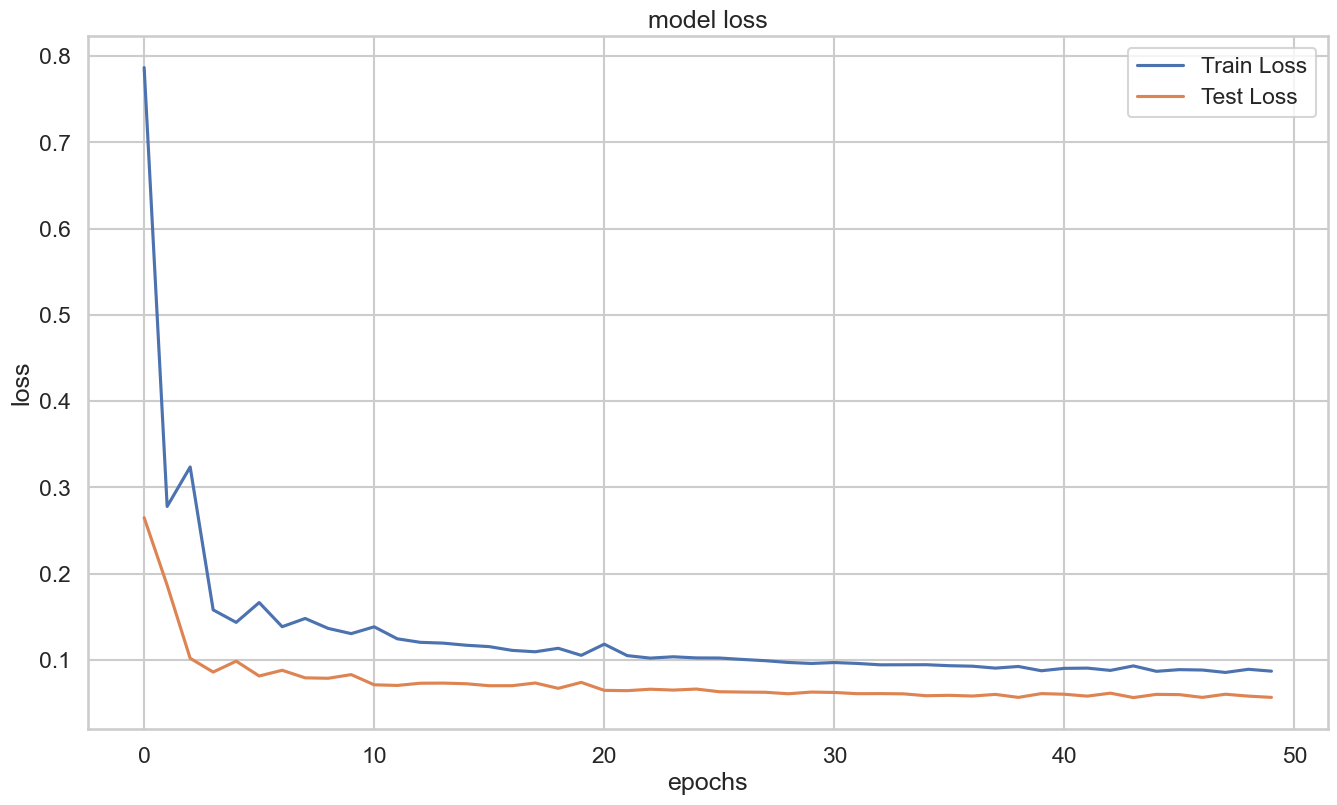

In [16]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig('length_hours{}epochs{}batch_size{}verbose{}Dense{}-{}-{}'.format(length_hours,epochs,batch_size,verbose,32,8,1))
plt.show();

## iii) Prediction and Evaluation

In [17]:
# predict test week, save results

prediction = mdl.predict(X_test)
df_results['ANN Forecast'] = prediction

6/6 [==============================] - 0s 1ms/step


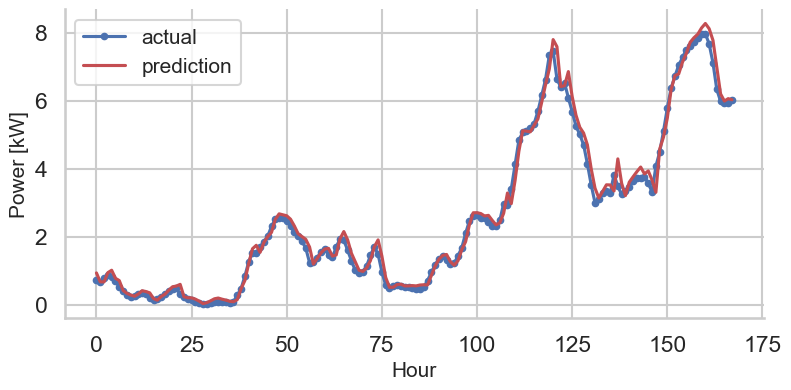

In [18]:
# to do: Plots aneinander angleichen (Größe, Achsenbeschriftung), evtl. einfach sns.lineplot(df_results) ?

week_times=[x for x in range(len(Y_test))]
plt.figure(figsize=(8,4))
plt.plot(week_times, Y_test, marker='.', label="actual")
plt.plot(week_times, prediction, 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Power [kW]', size=15)
plt.xlabel('Hour', size=15)
plt.legend(fontsize=15)
plt.savefig('PredictionSerieslength_hours{}epochs{}batch_size{}verbose{}Dense{}-{}-{}'.format(length_hours,epochs,batch_size,verbose,32,8,1))
plt.show();

<AxesSubplot: >

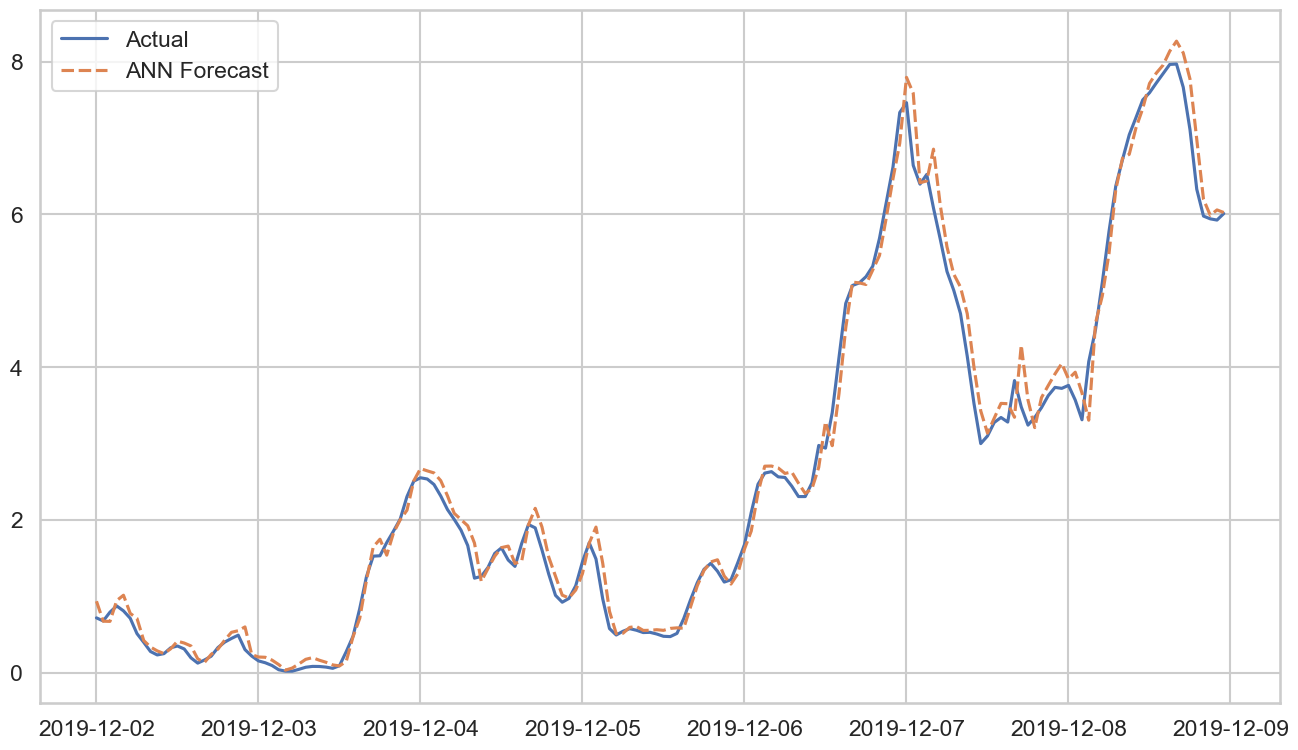

In [19]:
# gleiche Grafik wie oben, nur im einheitlichen Format der anderen Grafiken
plt.figure(figsize=(16, 9))
df = pd.DataFrame()
df["time"] = df_results["time"]
df.set_index("time")
df["Actual"] = Y_test
df["ANN Forecast"] = prediction
sns.lineplot(df)

In [20]:
train_score = mdl.evaluate(X_train,Y_train)
print('Train Root Mean Squared Error(RMSE): {}; Train Mean Absolute Error(MAE) : {} '.format(np.sqrt(train_score[1]), train_score[2]))
test_score = mdl.evaluate(X_test, Y_test)
print('Test Root Mean Squared Error(RMSE): {}; Test Mean Absolute Error(MAE) : {} '.format(np.sqrt(test_score[1]), test_score[2]))

250/250 [==============================] - 0s 973us/step - loss: 0.0817 - mse: 0.0817 - mae: 0.1949
Train Root Mean Squared Error(RMSE): 0.28581977098660527; Train Mean Absolute Error(MAE) : 0.19488348066806793 
6/6 [==============================] - 0s 3ms/step - loss: 0.0566 - mse: 0.0566 - mae: 0.1643
Test Root Mean Squared Error(RMSE): 0.23791306613751942; Test Mean Absolute Error(MAE) : 0.16433894634246826 


# 2c) COMPARISON

In [78]:
df_results

,time,Actual,Naive Forecast,ANN Forecast
2019-12-02 00:00:00,2019-12-02 00:00,0.719,2.822000,0.917928
2019-12-02 01:00:00,2019-12-02 01:00,0.679,2.734143,0.620489
2019-12-02 02:00:00,2019-12-02 02:00,0.794,2.649143,0.701103
2019-12-02 03:00:00,2019-12-02 03:00,0.875,2.536143,0.937079
2019-12-02 04:00:00,2019-12-02 04:00,0.811,2.529286,0.917030
...,...,...,...,...
2019-12-08 19:00:00,2019-12-08 19:00,6.330,1.978571,6.944942
2019-12-08 20:00:00,2019-12-08 20:00,5.978,2.073286,6.123126
2019-12-08 21:00:00,2019-12-08 21:00,5.942,2.186000,6.049237
2019-12-08 22:00:00,2019-12-08 22:00,5.926,2.299571,6.096277


<AxesSubplot: >

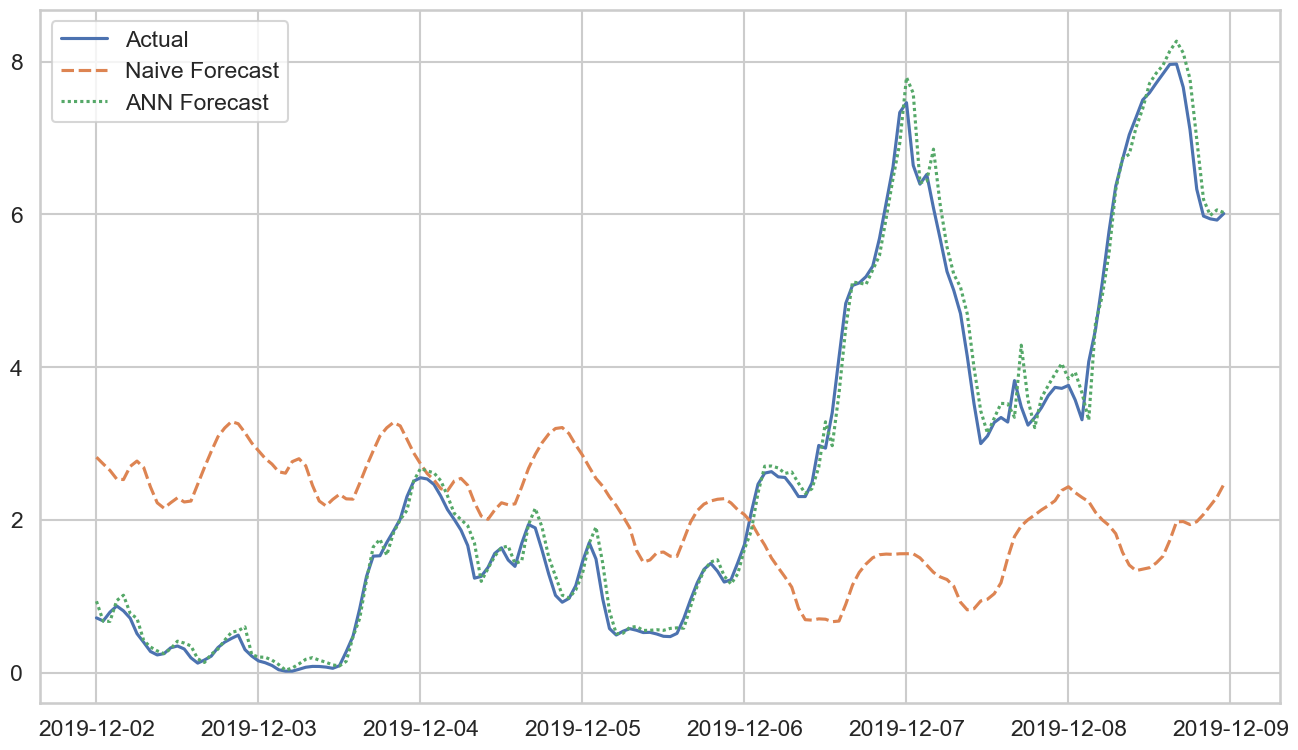

In [21]:
plt.figure(figsize=(16, 9))
sns.lineplot(df_results)